<a href="https://colab.research.google.com/github/codeskavy/Virtual_Tryon/blob/main/Part1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!nvidia-smi

Tue Jul 30 22:11:02 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   50C    P8              10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [ ]:
import os
HOME = os.getcwd()
print(HOME)

/content


In [ ]:
!git clone https://github.com/IDEA-Research/GroundingDINO.git
%cd {HOME}/GroundingDINO
!git checkout -q 57535c5a79791cb76e36fdb64975271354f10251
!pip install -q -e .

fatal: destination path 'GroundingDINO' already exists and is not an empty directory.
/content/GroundingDINO
  Preparing metadata (setup.py) ... done


In [ ]:
!pip install 'git+https://github.com/facebookresearch/segment-anything.git'

  Cloning https://github.com/facebookresearch/segment-anything.git to /tmp/pip-req-build-stzf0szs
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/segment-anything.git /tmp/pip-req-build-stzf0szs
  Resolved https://github.com/facebookresearch/segment-anything.git to commit 6fdee8f2727f4506cfbbe553e23b895e27956588
  Preparing metadata (setup.py) ... done


In [ ]:
!pip install torch

In [ ]:
!pip install torchvision

In [ ]:
!pip install supervision==0.12.0

  Using cached supervision-0.12.0-py3-none-any.whl.metadata (12 kB)
Using cached supervision-0.12.0-py3-none-any.whl (48 kB)
  Attempting uninstall: supervision
    Found existing installation: supervision 0.4.0
    Uninstalling supervision-0.4.0:
      Successfully uninstalled supervision-0.4.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
groundingdino 0.1.0 requires supervision==0.4.0, but you have supervision 0.12.0 which is incompatible.


In [ ]:
%cd {HOME}
!mkdir -p {HOME}/weights
%cd {HOME}/weights
!wget -q https://github.com/IDEA-Research/GroundingDINO/releases/download/v0.1.0-alpha/groundingdino_swint_ogc.pth

/content
/content/weights


In [ ]:
!wget -q https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth

In [ ]:
%cd {HOME}
import torch

DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(DEVICE)

/content
cuda:0


In [ ]:
GROUNDING_DINO_CONFIG_PATH = '/content/GroundingDINO/groundingdino/config/GroundingDINO_SwinT_OGC.py'
GROUNDING_DINO_CHECKPOINT_PATH = '/content/weights/groundingdino_swint_ogc.pth'

In [ ]:
from groundingdino.util.inference import Model
GD_model = Model(model_config_path=GROUNDING_DINO_CONFIG_PATH, model_checkpoint_path=GROUNDING_DINO_CHECKPOINT_PATH)


ModuleNotFoundError: No module named 'groundingdino'

In [ ]:
import cv2
image_bgr = cv2.imread('/content/Screenshot 2024-07-15 at 5.25.02 PM.png')
image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)
image_original = image_bgr

print(image_bgr.shape)

image_bgr = cv2.resize(image_bgr, (1024, 1024))
image_rgb = cv2.resize(image_rgb, (1024, 1024))
image_original = cv2.resize(image_original, (1024, 1024))

print(image_bgr.shape)



(813, 760, 3)
(1024, 1024, 3)


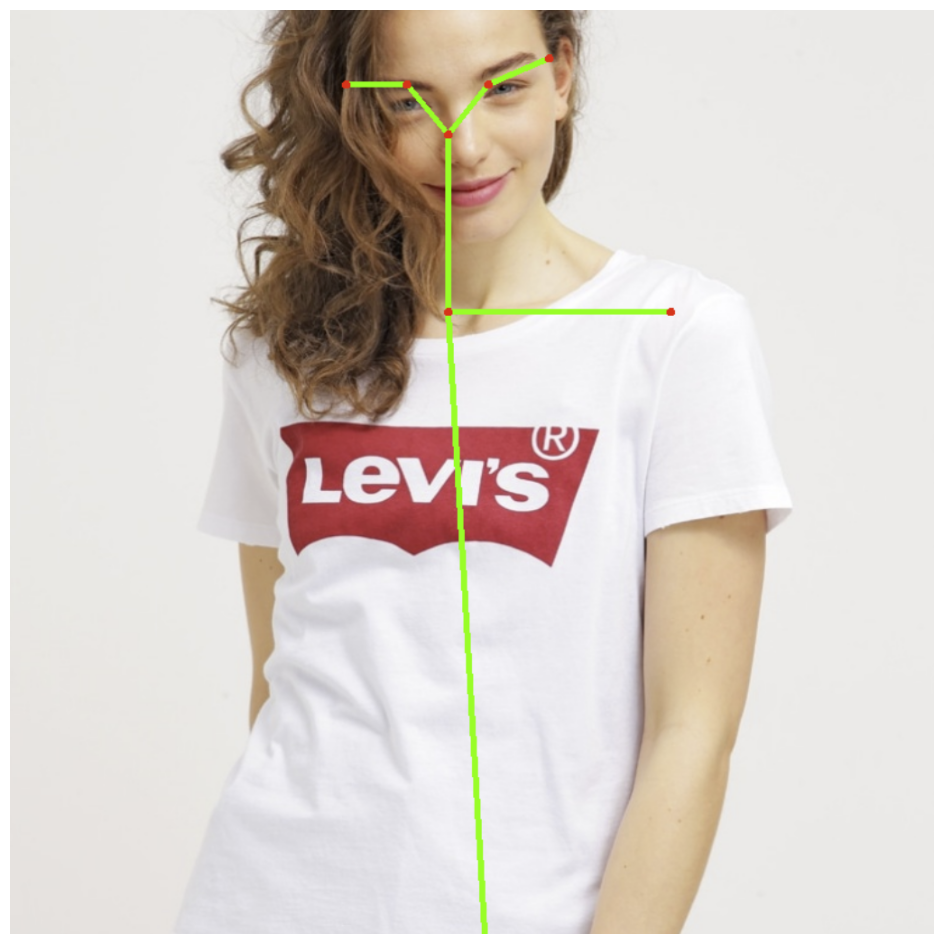

In [ ]:
import supervision as sv
sv.plot_image(image_bgr)

In [ ]:
# detect objects
CLASSES = ['tshirt', 'top']
detections = GD_model.predict_with_classes(
    image=image_rgb,
    classes=CLASSES,
    box_threshold=0.35,
    text_threshold=0.25
)

print(detections)

/usr/local/lib/python3.10/dist-packages/transformers/modeling_utils.py:1060: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:464: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.4 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:91: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(


Detections(xyxy=array([[ 182.94891,  260.866  ,  867.56866, 1021.0781 ]], dtype=float32), mask=None, confidence=array([0.83203256], dtype=float32), class_id=array([0]), tracker_id=None)


In [ ]:
print(detections.xyxy, type(detections.xyxy))
detected_boxes = detections.xyxy
class_id = detections.class_id
print(class_id)

[[ 182.94891  260.866    867.56866 1021.0781 ]] <class 'numpy.ndarray'>
[0]


In [ ]:
import supervision as sv
box_annotator = sv.BoxAnnotator()
annotated_frame = box_annotator.annotate(scene=image_bgr.copy(), detections=detections, skip_label=False, labels=[class_id])
sv.plot_image(annotated_frame)


TypeError: Can't convert object to 'str' for 'text'

In [ ]:
MODEL_TYPE = "vit_h"
CHECKPOINT_PATH = '/content/weights/sam_vit_h_4b8939.pth'

from segment_anything import sam_model_registry, SamPredictor

sam = sam_model_registry[MODEL_TYPE](checkpoint=CHECKPOINT_PATH).to(device=DEVICE)

mask_predictor = SamPredictor(sam)


In [ ]:
import numpy as np
mask_annotator =  sv.MaskAnnotator(color=sv.Color.blue())
segmented_mask = []
counter = 0
for mybox in detected_boxes:
    mybox = np.array(mybox)
    print(mybox)


    mask_predictor.set_image(image_rgb)
    masks, scores, logits = mask_predictor.predict(
        point_coords=None,
        point_labels=None,
        box=mybox,
        multimask_output=False
    )

    segmented_mask.append(masks)
    print(len(masks), masks.shape)

# plot mask on image using supervision
    detections = sv.Detections(
        xyxy=sv.mask_to_xyxy(masks=masks),
        mask=masks
    )

    detections = detections[detections.area == np.max(detections.area)]
    print(CLASSES[class_id[counter]])

    annotated_image = box_annotator.annotate(scene=image_original.copy(), detections=detections, skip_label=False, labels=[CLASSES[class_id[counter]]])
    annotated_image = mask_annotator.annotate(scene=annotated_image.copy(), detections=detections)
    image_original = annotated_image

    counter+=1

Plot image using Supervion

In [ ]:
sv.plot_images_grid(
    images=[image_bgr, annotated_image],
    grid_size=(1,2),
    titles=['Original Image', 'Mask Image']

)


In [ ]:
print(len(segmented_mask), type(segmented_mask[0]), segmented_mask[0].shape)

for i in range(len(segmented_mask)):

  segmented_mask[i] = segmented_mask[i].transpose(1,2,0)
  segmented_mask[i] = np.array(segmented_mask[i]*255).astype('uint8')
  segmented_mask[i]  = cv2.cvtColor(segmented_mask[i] , cv2.COLOR_GRAY2BGR)


print(segmented_mask[0].shape)

In [ ]:
sv.plot_images_grid(
    images=segmented_mask,
    grid_size=(1, len(segmented_mask)),

)

In [ ]:
segmented_image = segmented_mask[0]

for i in range(len(segmented_mask)):
  try:
    segmented_image = cv2.bitwise_or(segmented_image, segmented_mask[i+1])
  except:
    pass

sv.plot_image(segmented_image)

In [ ]:
segmented_image = cv2.bitwise_and(segmented_image, image_bgr)
sv.plot_image(segmented_image)

In [ ]:
segmented_image[np.where((segmented_image == [0, 0, 0]).all(axis=2))] = [255, 255, 255]
sv.plot_image(segmented_image)

In [ ]:
sv.plot_images_grid(
    images=[image_bgr, annotated_image, segmented_image],
    grid_size=(1, 3),
    titles=['Original Image', 'Annotated Image', 'Segmented Image'],
    #size=(48,48)

)